In [1]:
!pip install sortedcontainers
from metawars_api import *
import pandas as pd
import numpy as np
from sortedcontainers import SortedList
from tqdm import tqdm
import os

In [2]:
from abc import ABC

class GeneticAlgorithm(ABC):
    def __init__(self):
        super().__init__()

        self.population = None
        self.population_size = None

        self.alpha_s_cur = None # current survival rate
        self.alpha_s_min = None # min survival rate
        self.alpha_s_max = None # max survival rate

        self.alpha_r_cur = None # current reproduction rate
        self.alpha_r_min = None # min reproduction rate
        self.alpha_r_max = None # max reproduction rate

        self.alpha_m_cur = None # current mutation rate
        self.alpha_m_max = None # max mutation rate
        self.alpha_m_min = None # min mutation rate


    def get_individual(self):
        raise NotImplementedError()
    
    def get_population(self):
        self.population = [self.get_individual() for i in range(self.population_size)]

    def update_rates(self, iterations, iter, function):
        self.alpha_s_cur = function(self.alpha_s_min, self.alpha_s_max, iterations, iter)
        self.alpha_r_cur = function(self.alpha_r_min, self.alpha_r_max, iterations, iter)
        self.alpha_m_cur = function(self.alpha_m_max, self.alpha_m_min, iterations, iter)

    def evaluate(self):
        raise NotImplementedError()
    
    def reproduce(self, x, y):
        raise NotImplementedError()
    
    def mutate(self, x):
        raise NotImplementedError()
    
    def solve(self, iters: int, population_size: int, alpha_s_min: float, alpha_s_max: float, alpha_r_min: float, alpha_r_max: float, alpha_m_min: float, alpha_m_max: float, function):
        
        # set parameters for execution
        self.population_size = population_size

        self.alpha_s_cur = alpha_s_min 
        self.alpha_s_max = alpha_s_max
        self.alpha_s_min = alpha_s_min

        self.alpha_r_cur = alpha_r_min
        self.alpha_r_max = alpha_r_max 
        self.alpha_r_min = alpha_r_min

        self.alpha_m_cur = alpha_m_max
        self.alpha_m_min = alpha_m_min
        self.alpha_m_max = alpha_m_max 

        self.get_population()


        for i in tqdm(range(iters)):

            evaluation = self.evaluate()
            sorted_individuals = [x[1] for x in sorted(enumerate(self.population), key=lambda x: evaluation[x[0]], reverse=True)] # high is better
            
            survivors_count = int(self.population_size * self.alpha_s_cur)
            offspring_count = int(self.population_size * self.alpha_r_cur)
            mutation_count = int(self.population_size * self.alpha_m_cur)

            survivors = sorted_individuals[:survivors_count]

            parents = sorted_individuals[:offspring_count] # parents will be the top % of the population
            offspring = [self.reproduce(random.choice(parents), random.choice(parents)) for i in range(offspring_count)]
            
            mutations = [self.mutate(x) for x in random.sample(sorted_individuals, mutation_count)]

            remaining_count = self.population_size - survivors_count - offspring_count - mutation_count
            randoms = [self.get_individual() for i in range(remaining_count)]

            self.population = survivors + offspring + mutations + randoms

            self.update_rates(iters, i+1, function)

        evaluation = self.evaluate()
        return list(zip(self.population, evaluation))


In [3]:
class ArmyGeneticAlgorithm(GeneticAlgorithm):

    def get_individual(self):
        budget = self.army_budget
        army = []

        while budget > 0:
            limit = self.units_by_cost.bisect_key_right(budget) - 1 # get the index of the most expensive unit cheaper than cost
            
            if (limit < 0): 
                return army
            
            sel = random.randint(0, limit)
            
            unit = self.units_by_cost[sel][2]
            unit.id = self.units_by_cost[sel][0]

            budget -= unit.cost
            army.append(unit)

        return army
    

    def evaluate(self):
        armies = self.population
        results = np.zeros(self.population_size)

        with tqdm(total=self.population_size * (self.population_size - 1) / 2, desc="Evaluation", colour='green') as pbar:
            for i in range(len(armies)):
                for j in range(i+1, len(armies)):

                    for a,b in [(i,j), (j,i)]:
                        res = simulation(armies[a], armies[b], False)
                        
                        if (res[0] > res[1]):
                            results[a] += 1
                        else:
                            results[b] += 1
                        
                    pbar.update(1)

        lines = [ f"{results[i]}, " + ",".join(str(u.id)  for u in self.population[i]) + "\n" for i in range(len(results))]

        with open(self.file, 'a') as file:
            file.writelines(lines)

        return results


    def reproduce(self, x, y):
        cost = int(self.army_budget / 2  + self.army_budget / 2 * random.random())
        new_army = []
        
        for u in random.sample(x, len(x)):
            if (u.cost <= cost):
                new_army.append(u)
                cost -= u.cost
        
        cost = self.army_budget - army_cost(new_army)
        
        for u in random.sample(y, len(y)):
            if (u.cost <= cost):
                new_army.append(u)
                cost -= u.cost

        return new_army     
    
    def mutate(self, army):
        army = army.copy()
        if random.random() <= 0.5:
            for i in range(3):
                j, k = np.random.randint(0,len(army)-1),np.random.randint(0,len(army)-1)
                army[j], army[k] = army[k], army[j]
        else:
            budget = self.army_budget - army_cost(army)
            for i in range(3):
                j = np.random.randint(0, len(army)-1)
                budget += army[j].cost
                limit = self.units_by_cost.bisect_key_right(budget) - 1
                if (limit >= 0):
                    army[j] = self.units_by_cost[limit][2]
                budget -= army[j].cost

        return army
    
    def solve(self, output_file: str, max_level: int, army_budget: int, iters: int, population_size: int, alpha_s_min: float, alpha_s_max: float, alpha_r_min: float, alpha_r_max: float, alpha_m_min: float, alpha_m_max: float, function):
        
        self.army_budget = army_budget
        self.file = output_file

        with open(self.file, 'w') as output_file:
            pass # clean file

        unit_types = ["peasant", "swordman", "spearman", "archer", "defender", "horseman", "sniper", "knight", "elefant"]
        equipment_types = ["wood", "steel", "diamond"]

        units = []
        c = 1
        for ut in unit_types:
            for wt in equipment_types:
                for at in equipment_types:
                    for l in range(1,max_level+1):
                        u = Unit(ut, wt, at, l)
                        if (u.cost) > army_budget:
                            break
                        units.append((c, u.cost, u, u.unit_type))
                        c =  c + 1
        
        self.units_by_cost = SortedList(units, key=lambda x: x[1])
        
        return super().solve(iters, population_size, alpha_s_min, alpha_s_max, alpha_r_min, alpha_r_max, alpha_m_min, alpha_m_max, function)

In [4]:
expo_decay = lambda xmin, xmax, iterations, iter: xmin + (xmax - xmin) * (1.01 ** iter - 1) / (1.01 ** iterations - 1)
linear_update = lambda xmin, xmax, iterations, iter: xmin + (xmax - xmin) * (iter - 1) / (iterations - 1)

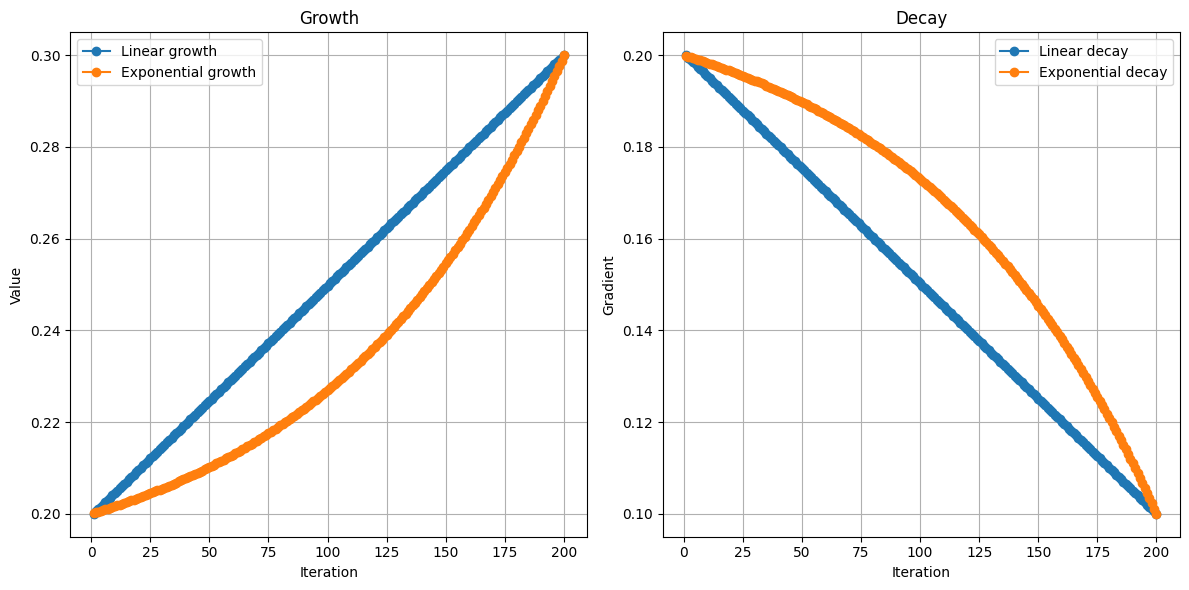

In [5]:

import matplotlib.pyplot as plt

iterations = 200

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, iterations+1), [linear_update(0.2,0.3,iterations,i) for i in range(1,iterations+1)], marker='o', label='Linear growth')
plt.plot(range(1, iterations+1), [expo_decay(0.2,0.3,iterations,i) for i in range(1,iterations+1)], marker='o', label='Exponential growth')
plt.title("Growth")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, iterations+1), [linear_update(0.2,0.1,iterations,i) for i in range(1,iterations+1)], marker='o', label='Linear decay')
plt.plot(range(1, iterations+1), [expo_decay(0.2,0.1,iterations,i) for i in range(1,iterations+1)], marker='o', label='Exponential decay')
plt.title("Decay")
plt.xlabel("Iteration")
plt.ylabel("Gradient")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
model = ArmyGeneticAlgorithm()

In [6]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
res = model.solve(output_file="results_no_max_level.data", max_level=10000, army_budget=100000, iters=200, population_size=100, alpha_s_min=0.2, alpha_s_max=0.3, alpha_r_min=0.4, alpha_r_max=0.5, alpha_m_min=0.1, alpha_m_max=0.2, function=expo_decay)

  0%|          | 0/200 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 4950/4950.0 [00:02<00:00, 1772.91it/s]
Evaluation: 100%|██████████| 4950/4950.0 [00:04<00:00, 1026.71it/s]
Evaluation: 100%|██████████| 4950/4950.0 [00:06<00:00, 787.23it/s] 
Evaluation: 100%|██████████| 4950/4950.0 [00:07<00:00, 629.03it/s] 
Evaluation: 100%|██████████| 4950/4950.0 [00:10<00:00, 490.15it/s]
Evaluation: 100%|██████████| 4950/4950.0 [00:13<00:00, 368.44it/s]
Evaluation:  42%|████▏     | 2063/4950.0 [00:09<00:13, 208.61it/s]
  3%|▎         | 6/200 [00:55<29:45,  9.21s/it]


KeyboardInterrupt: 